# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 29: Hierarchical Risk Parity (HRP) Portfolio Optimization with Constraints

## 1. Downloading the data:

In [20]:
import pandas as pd
import datetime
import yfinance as yf
import backtrader as bt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Date range
start = '2010-01-01'
end = '2023-05-24'

# Tickers of assets
assets = ['^KS200',
          '229200.KS',
          '143850.KS',
          '195930.KS',
          '238720.KS',
          '192090.KS',
          '148070.KS',
          '136340.KS',
          '182490.KS',
          '280940.KS',
          '130680.KS',
          '114800.KS',
          '138230.KS',
          '139660.KS',
          '130730.KS']

lables = ['KOSPI',
    'KOSDAQ',
    'S&P500',
    'STOXX50',
    'Nikkei225',
    'CSI300',
    '국채10년',
    '우량회사채',
    '해외채권',
    '금',
    'WTI',
    'KOSPI-Short',
    'US-Long',
    'US-Short',
    'MMF',]

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = lables

[*********************100%***********************]  15 of 15 completed


In [21]:
# Calculating returns

Y = data[lables].pct_change().dropna()
display(Y.head())

,KOSPI,KOSDAQ,S&P500,STOXX50,Nikkei225,CSI300,국채10년,우량회사채,해외채권,금,WTI,KOSPI-Short,US-Long,US-Short,MMF
Date,,,,,,,,,,,,,,,
2017-11-10,0.003439,0.003606,-0.000049,-0.000049,0.001310,-0.000448,-0.002113,-0.000087,-0.000902,0.016520,-0.009583,0.019814,-0.007950,-0.003014,-0.003500
2017-11-13,0.004284,-0.002395,0.000049,-0.000980,0.003489,-0.003136,-0.002443,-0.003651,0.000000,0.003792,-0.003366,0.040048,-0.013937,0.006549,-0.004852
2017-11-14,0.000853,-0.006002,-0.000049,-0.000147,-0.002173,0.002247,-0.001143,-0.001221,-0.003610,-0.003778,-0.008020,0.038506,-0.001060,-0.001502,-0.002124
2017-11-15,0.004263,-0.028986,0.000098,0.000245,-0.005227,0.004484,-0.000817,0.001441,0.000453,-0.013543,-0.007660,0.026799,-0.014149,-0.002005,-0.004346
2017-11-16,-0.005093,0.007463,-0.000049,0.000736,-0.009632,0.011607,0.000000,0.003358,-0.002263,-0.001098,0.004288,0.018949,0.012558,0.003014,0.006593


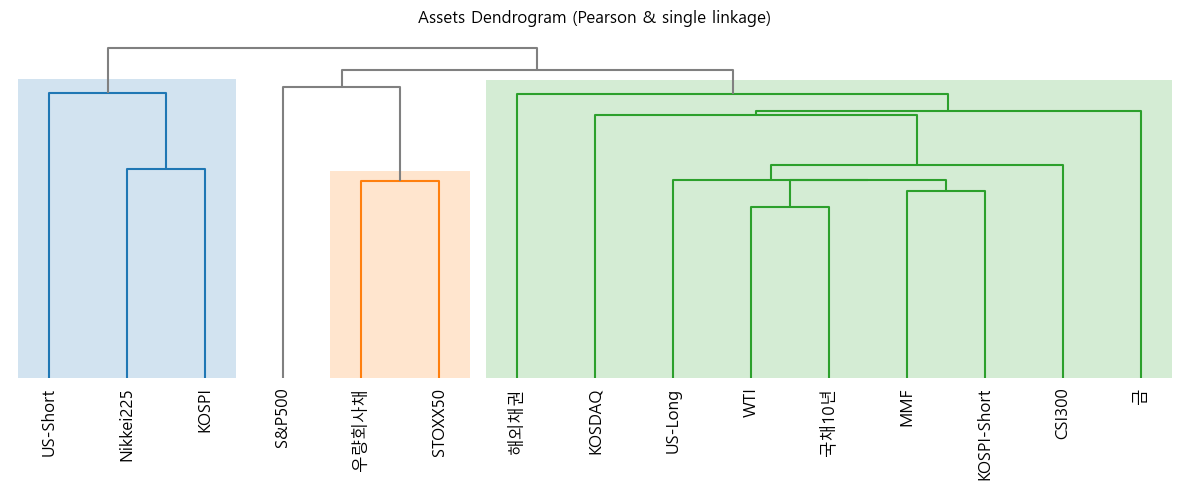

In [22]:
import riskfolio as rp

# Plotting Assets Clusters

ax = rp.plot_dendrogram(returns=Y,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

The dendrogram above suggest that optimal number of clusters are four. However HRP portfolios don't use a number of clusters as input.

## 2. Estimating HRP Portfolio

This is the original model proposed by López de Prado (2016). Riskfolio-Lib expand this model to 32 risk measures.

### 2.1 Calculating the HRP portfolio

In [23]:
# Building the portfolio object
port = rp.HCPortfolio(returns=Y)

# Estimate optimal portfolio:

model = 'HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)

,KOSPI,KOSDAQ,S&P500,STOXX50,Nikkei225,CSI300,국채10년,우량회사채,해외채권,금,WTI,KOSPI-Short,US-Long,US-Short,MMF
weights,0.001657,0.000185,0.608259,0.323496,0.008948,0.00509,0.000554,0.025869,0.018263,0.000876,0.000541,0.000295,0.000797,0.004481,0.000691


### 2.2 Plotting portfolio composition

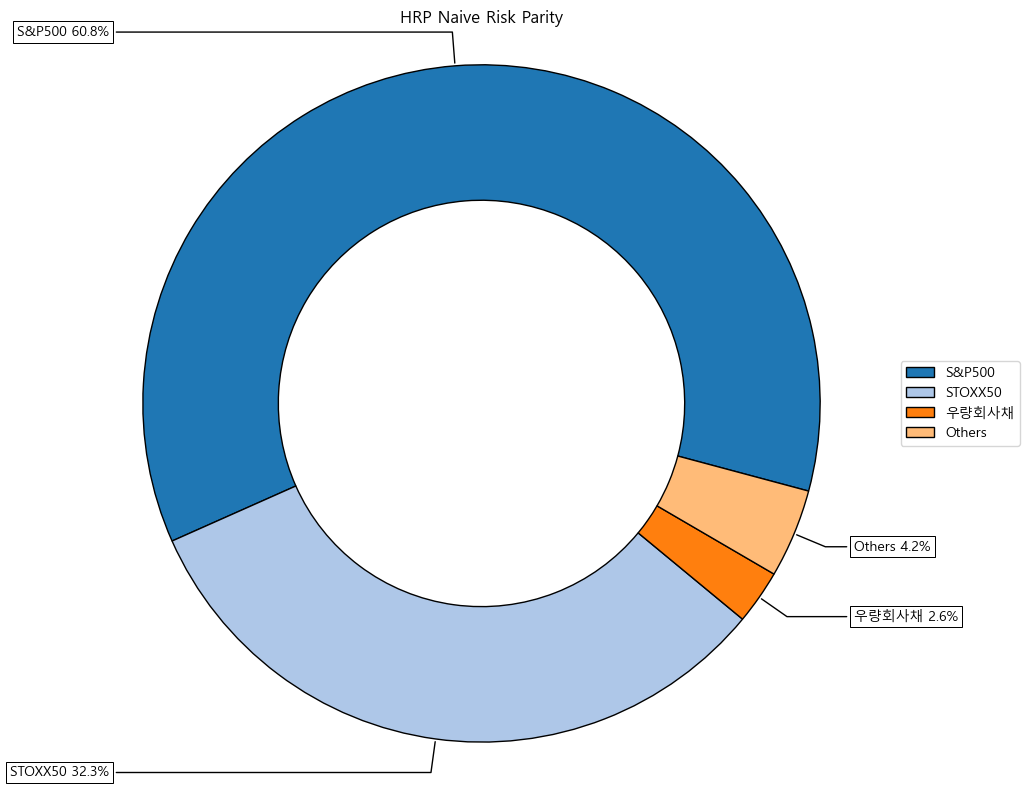

In [24]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

### 2.3 Plotting Risk Contribution

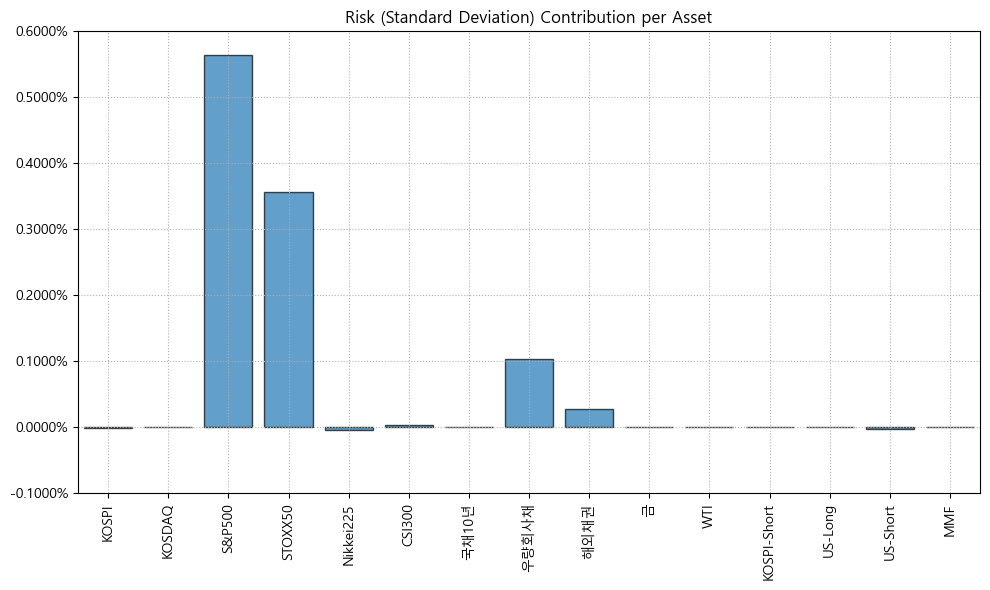

In [25]:
# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

## 3. Estimating HRP Portfolio with Constraints

This is a modification of HRP model proposed by Johann Pfitzinger & Nico Katzke (2019).

### 3.1 Building the HRP portfolio constraints

In [30]:
asset_classes = {'Assets': ['KOSPI', 'KOSDAQ',
                            'S&P500', 'STOXX50', 'Nikkei225', 'CSI300',
                            '국채10년', '우량회사채',
                            '해외채권',
                            '금', 'WTI',
                            'KOSPI-Short',
                            'US-Long', 'US-Short',
                            'MMF'],

                 'Industry': ['DS','DS',
                              'FS', 'FS', 'FS', 'FS',
                              'Bond', 'Bond',
                              'Bond',
                              'COM', 'COM',
                              'Inverse',
                              'FX', 'FX',
                              'Cash'],
                }

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False, False,
                            False, False, False, False, False,
                            False, False, False,
                            False, False,
                            
                            False, False,
                            False, False,
                            False, False,
                            False, False,
                            False,
                            False,
                            False,],

               'Type': ['Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets',
                        'Assets', 'Assets', 'Assets', 'Assets', 'Assets',
                        'Assets', 'Assets', 'Assets',
                        'Assets', 'Assets', #자산

                        'Classes', 'Classes',
                        'Classes', 'Classes',
                        'Classes', 'Classes',
                        'Classes', 'Classes',
                        'Classes',
                        'Classes',
                        'Classes'],

               'Set': ['', '', '', '', '', '', # 6
                       '', '', '', '', '', # 5
                       '', '', '', '', '', # 5

                       'Industry', 'Industry',
                       'Industry', 'Industry',
                       'Industry', 'Industry',
                       'Industry', 'Industry',
                       'Industry',
                       'Industry',
                       'Industry'],

               'Position': ['KOSPI', 'KOSDAQ', 'S&P500', 'STOXX50', 'Nikkei225', 'CSI300',
                            '국채10년', '우량회사채', '해외채권', '금', 'WTI',
                            'KOSPI-Short', 'US-Long', 'US-Short',
                            'MMF', '해외채권',
                        
                        'DS', 'DS',
                        'FS', 'FS',
                        'Bond', 'Bond',
                        'COM', 'COM',
                        'Inverse',
                        'FX',
                        'Cash'],

               'Sign': ['<=', '<=', '<=', '<=', '<=', '<=',
                        '<=', '<=', '<=', '<=', '<=',
                        '<=', '<=', '<=',
                        '>=', '>=', #MMF, 채권 하한

                        '<=', '>=', #자산군
                        '<=', '>=',
                        '<=', '>=',
                        '<=', '>=',
                        '<=',
                        '<=',
                        '<='],
               'Weight': [0.40, 0.20, 0.20, 0.20, 0.20, 0.20, # KOSPI KOSDAQ S&P STO Nik CSI 상한
                          0.50, 0.40, 0.40, 0.15, 0.15, # 국채 회사채 해외채 금 원유 상한
                          0.20, 0.20, 0.20, # 인버스 FX FX 상한
                          0.01, 0.05, # MMF, 채권 하한
                          
                          0.40, 0.10, # 국내주식 상하한
                          0.40, 0.10, # 해외주식 상하한
                          0.60, 0.20, # 채권 상하한
                          0.20, 0.05, # 원자재 상하한
                          0.20,  # 인버스 상한
                          0.20,  # FX 상한
                          0.50] # 현금 상한
                          }

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight
0,False,Assets,,KOSPI,<=,0.40
1,False,Assets,,KOSDAQ,<=,0.20
2,False,Assets,,S&P500,<=,0.20
3,False,Assets,,STOXX50,<=,0.20
4,False,Assets,,Nikkei225,<=,0.20
5,False,Assets,,CSI300,<=,0.20
6,False,Assets,,국채10년,<=,0.50
7,False,Assets,,우량회사채,<=,0.40
8,False,Assets,,해외채권,<=,0.40
9,False,Assets,,금,<=,0.15


In [60]:
Asset = ['KOSPI', 'KOSDAQ', 'S&P500', 'STOXX50', 'Nikkei225', 'CSI300', '국채10년', '우량회사채', '해외채권', '금', 'WTI', 'KOSPI-Short', 'US-Long', 'US-Short', 'MMF']
Industry = ['DS', 'DS', 'FS', 'FS', 'FS', 'FS', 'Bond', 'Bond', 'Bond', 'COM', 'COM', 'Inverse', 'FX', 'FX', 'Cash']

Disabled = [False] * 27
Type = ['All Classes'] * 11 + ['Assets'] * 16
Set = ['Industry'] * 11 + [''] * 16
Position = ['DS', 'DS', 'FS', 'FS', 'Bond', 'Bond', 'COM', 'COM', 'Inverse', 'FX', 'Cash',
            'KOSPI', 'KOSDAQ', 'S&P500', 'STOXX50', 'Nikkei225', 'CSI300',
            '국채10년', '우량회사채', '해외채권',
            '금', 'WTI', 'KOSPI-Short', 'US-Long', 'US-Short',
            'MMF', '해외채권']

# DS상하한(2), FS상하한(2), Bond상하한(2), COM상하한(2), Inverse(1), FX(1), Cash(1)
# KOSPI상한, #KOSDAQ상한, S&P상한, STO상한, Nik상한, CSI상한,
# 국채상한, 회사채상한, 해채상한,
# 금, WTI, 코숏, 달러롱, 달러숏,
# 현금하한, 해채하한
Sign = ['<=', '>=', '<=', '>=', '<=', '>=', '<=', '>=', '<=', '<=', '<=', 
        '<=', '<=', '<=', '<=', '<=', '<=',
        '<=', '<=', '<=',
        '<=', '<=', '<=', '<=', '<=',
        '>=', '>=']

Weight = [0.40, 0.10, 0.40, 0.10, 0.60, 0.20, 0.20, 0.05, 0.20, 0.20, 0.50,
          0.40, 0.20, 0.20, 0.20, 0.20, 0.20,
          0.50, 0.40, 0.40,
          0.15, 0.15, 0.20, 0.20, 0.20,
          0.01, 0.05]


constraints_list = [Asset, Industry, Disabled, Type, Set, Position, Sign, Weight]
for i in constraints_list:
    print(constraints_list.index(i) , len(i))

0 15
1 15
2 27
3 27
4 27
5 27
6 27
7 27


In [61]:
asset_classes = {'Assets': Asset,
                 'Industry': Industry,
                }

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': Disabled,
               'Type': Type,
               'Set': Set,
               'Position': Position,
               'Sign': Sign,
               'Weight': Weight,
}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight
0,False,All Classes,Industry,DS,<=,0.40
1,False,All Classes,Industry,DS,>=,0.10
2,False,All Classes,Industry,FS,<=,0.40
3,False,All Classes,Industry,FS,>=,0.10
4,False,All Classes,Industry,Bond,<=,0.60
5,False,All Classes,Industry,Bond,>=,0.20
6,False,All Classes,Industry,COM,<=,0.20
7,False,All Classes,Industry,COM,>=,0.05
8,False,All Classes,Industry,Inverse,<=,0.20
9,False,All Classes,Industry,FX,<=,0.20


In [62]:
asset_classes

,Assets,Industry
5,CSI300,FS
1,KOSDAQ,DS
0,KOSPI,DS
11,KOSPI-Short,Inverse
14,MMF,Cash
4,Nikkei225,FS
2,S&P500,FS
3,STOXX50,FS
12,US-Long,FX
13,US-Short,FX


### 3.2 Calculating the HRP portfolio with constraints

In [63]:
# Estimate optimal portfolio with constraints:

w_max, w_min = rp.hrp_constraints(constraints, asset_classes)

port.w_max = w_max
port.w_min = w_min

w_1 = port.optimization(model=model,
                        codependence=codependence,
                        rm=rm,
                        rf=rf,
                        linkage=linkage,
                        max_k=max_k,
                        leaf_order=leaf_order)

display(w_1.T)

,KOSPI,KOSDAQ,S&P500,STOXX50,Nikkei225,CSI300,국채10년,우량회사채,해외채권,금,WTI,KOSPI-Short,US-Long,US-Short,MMF
weights,0.002319,NaN,0.2,0.2,0.012519,6.706344e-17,0.07375,0.295,0.185393,1.154035e-17,0.0,0.01475,NaN,0.006269,0.01


In [64]:
w_max

CSI300         0.20
KOSDAQ         0.20
KOSPI          0.40
KOSPI-Short    0.20
MMF            1.00
Nikkei225      0.20
S&P500         0.20
STOXX50        0.20
US-Long        0.20
US-Short       0.20
WTI            0.15
국채10년          0.50
금              0.15
우량회사채          0.40
해외채권           0.40
dtype: float64

In [65]:
w_min

CSI300         0.00
KOSDAQ         0.00
KOSPI          0.00
KOSPI-Short    0.00
MMF            0.01
Nikkei225      0.00
S&P500         0.00
STOXX50        0.00
US-Long        0.00
US-Short       0.00
WTI            0.00
국채10년          0.00
금              0.00
우량회사채          0.00
해외채권           0.05
dtype: float64

### 3.3 Plotting portfolio composition

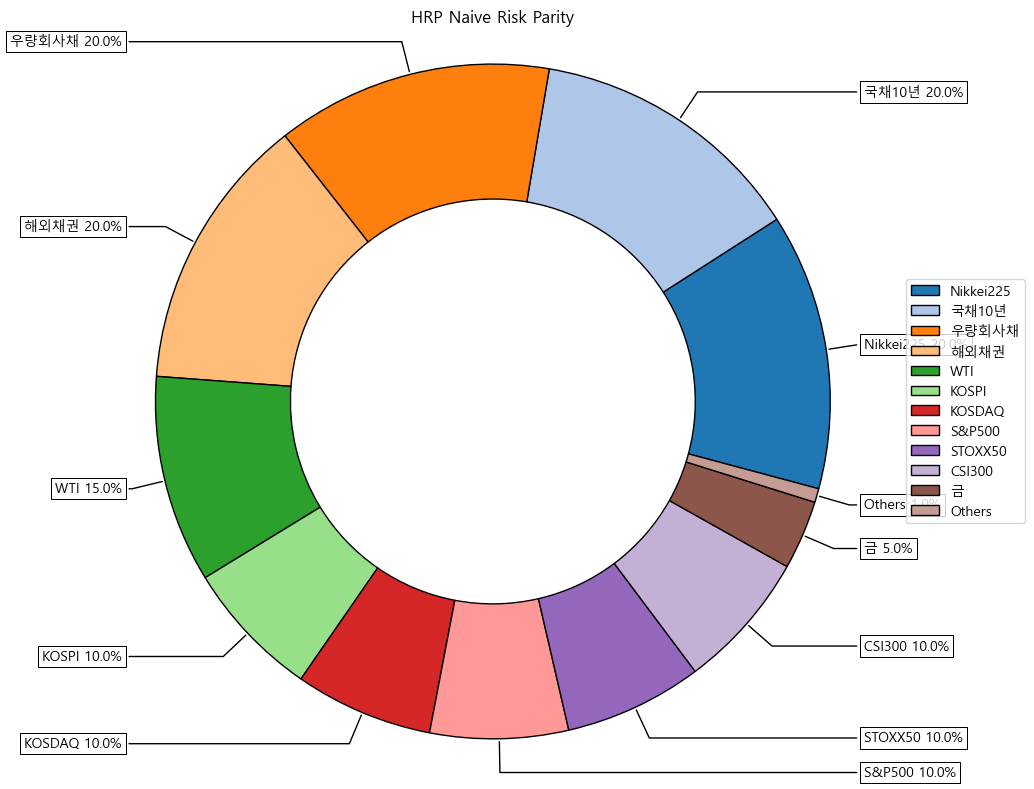

In [58]:
# Plotting the composition of the portfolio with constraints

ax = rp.plot_pie(w=w_1,
                 title='HRP Naive Risk Parity',
                 others=0.01,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

### 3.4 Plotting Risk Contribution

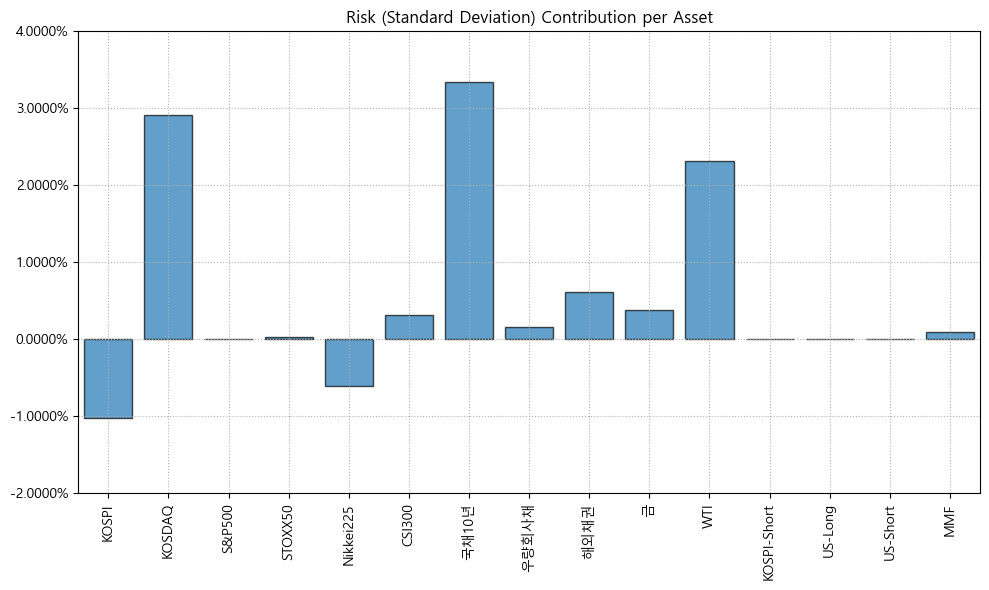

In [59]:
# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w_1,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)